# MC approaches

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import perf_counter

Let us first implement Black-Scholes formula whose result will be compared with the Asian call prices we find, for information.

In [3]:
def vanilla(
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> float:
    '''Returns the price of a vanilla call with the specified parameters under Black-Scholes model'''
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

## 1. Naive approach

In [34]:
def naive(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    means = s[:-1, ::].mean(axis=0)             # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    # 1.96*s[:-1, ::].std(axis=0).mean()/np.sqrt(m)
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results for varying strike $K$

In [42]:
fixed_n, fixed_m, fixed_r, fixed_S0 = 10**4, 100, .03, 100
Ks = np.linspace(90, 110, 11)

start = perf_counter()

result = {}
for fixed_T in [1/12, 1]:
    for fixed_sigma in [.15, .25]:
        fixed = []
        for K in Ks:
            est, ci = naive(fixed_n, fixed_m, fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            bs = vanilla(fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            fixed.append([est, bs, ci])
        fixed = np.array(fixed)
        result[(fixed_T, fixed_sigma)] = fixed

dur = perf_counter() - start
print(f'Duration: {dur:.2f} s')

Duration: 2.53 s


In [43]:
def plot_approach(res: np.ndarray, K_list: list, sigma_list: list, T_list: list):
    fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
    for i, T in enumerate(T_list):
        for j, sigma in enumerate(sigma_list):
            f = res[(T, sigma)]
            ax[i, j].plot(K_list, f[:, 1], color='tab:orange', linestyle='--', label='European call Black-Scholes price')
            ax[i, j].plot(K_list, f[:, 0], color='black', label='Asian call naive approach price')
            ax[i, j].scatter(K_list, f[:, 0] + f[:, 2], marker='v', color='tab:red')
            ax[i, j].scatter(K_list, f[:, 0] - f[:, 2], marker='^', color='tab:red', label='Confidence interval')
            ax[i, j].grid()
            ax[i, j].legend()
            if i==0:
                ax[i, j].annotate(f'$\sigma = {sigma}$', xy=(0.5, 1), xytext=(0, 10),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
            elif i==1:
                ax[i, j].set_xlabel(r'Strike (% of the spot)')
                ax[i, j].set_xticks([90 + 5*k for k in range(5)], [90 + 5*k for k in range(5)])
            if j==1:
                row_lab = '$T = 1$m' if i==0 else '$T = 1$y'
                ax[i, j].annotate(row_lab, xy=(1, 0.5), xytext=(30, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
    fig.tight_layout();

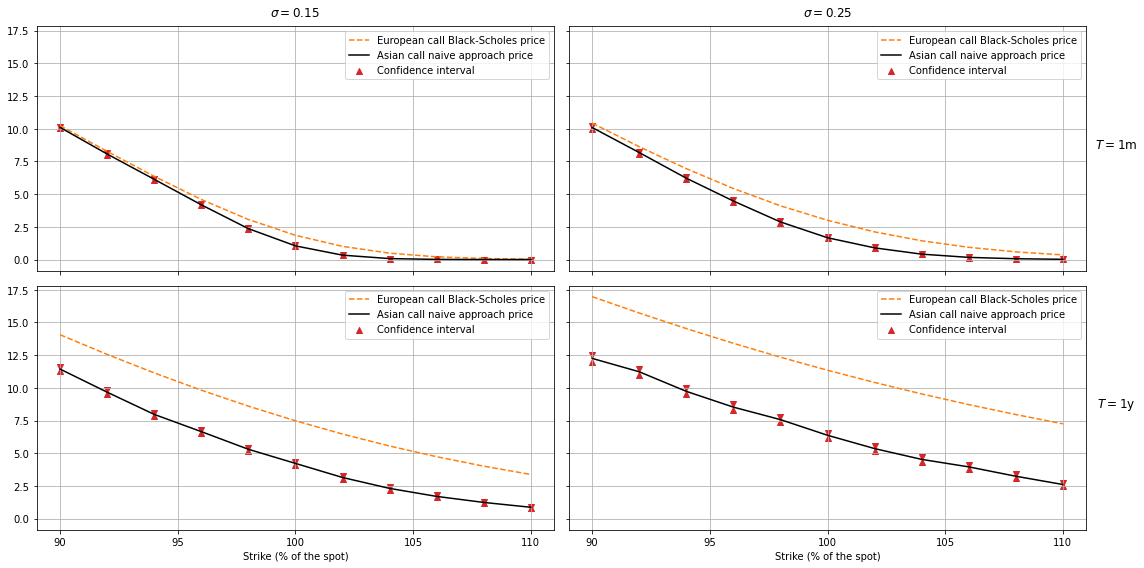

In [44]:
plot_approach(result, Ks, [.15, .25], [1/12, 1])

### Convergence properties

__Problem__: the above chart only shows the statistical error and not the discretization bias. As $\sqrt{n} \sim m$, they should be quite similar.

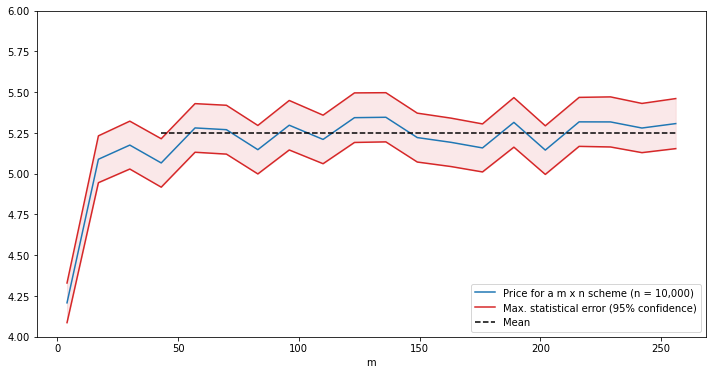

In [114]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .03, 100, 1, .2, 100

ms = np.linspace(4, 256, 20).astype('int')
fixed = []
for m in ms:
    est, ci = naive(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    fixed.append([est, ci])
bs = vanilla(fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 0], label=r'Price for a m x n scheme (n = 10,000)')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:red', label=r'Max. statistical error (95% confidence)')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:red')
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:red', alpha=.1)
ax.plot(ms[len(ms)//6:], np.mean(fixed[len(ms)//6:, 0])*np.ones(shape=ms[len(ms)//6:].shape), linestyle='--', color='black', label='Mean')
ax.set_xlabel('m')
ax.set_ylim(4, 6)
ax.legend(loc='lower right');

## 2. Improved Monte-Carlo

### 2.a Trapezoidal method

In [103]:
def trapeze(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    e = s[:-1, ::]*(1 + r*h/2 + dw/2)           # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results

Duration: 1.42 s


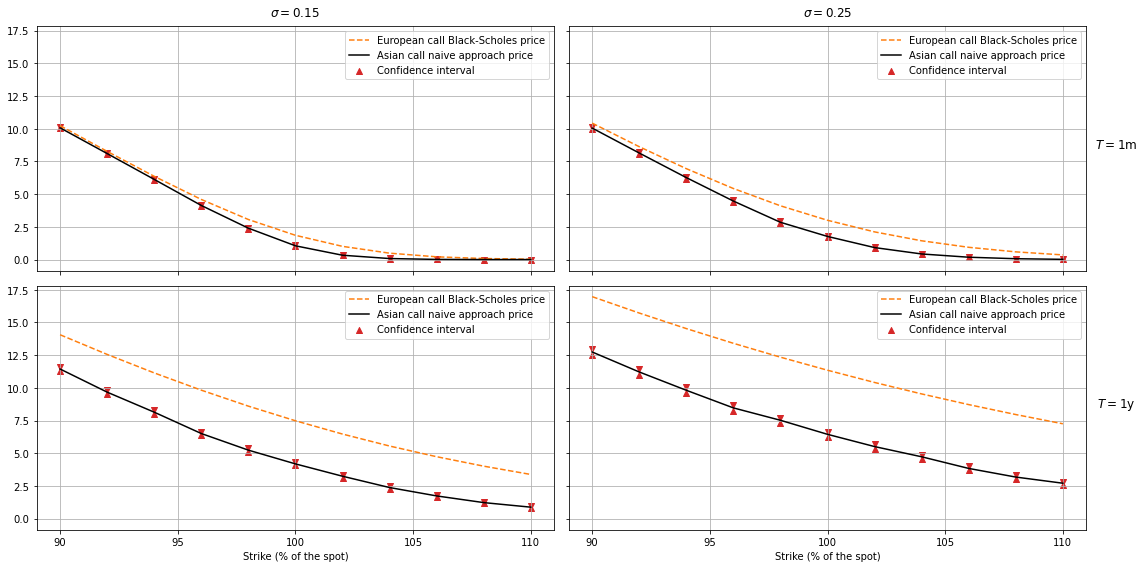

In [104]:
fixed_n, fixed_m, fixed_r, fixed_S0 = 10**4, 50, .03, 100
Ks = np.linspace(90, 110, 11)

start = perf_counter()

result = {}
for fixed_T in [1/12, 1]:
    for fixed_sigma in [.15, .25]:
        fixed = []
        for K in Ks:
            est, ci = trapeze(fixed_n, fixed_m, fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            bs = vanilla(fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            fixed.append([est, bs, ci])
        fixed = np.array(fixed)
        result[(fixed_T, fixed_sigma)] = fixed

dur = perf_counter() - start
print(f'Duration: {dur:.2f} s')
plot_approach(result, Ks, [.15, .25], [1/12, 1])

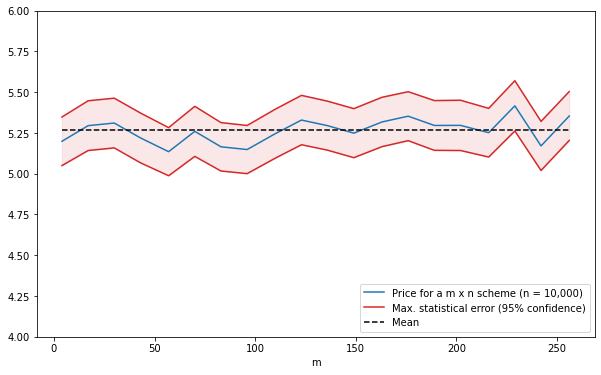

In [113]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .03, 100, 1, .2, 100

ms = np.linspace(4, 256, 20).astype('int')
fixed = []
for m in ms:
    est, ci = trapeze(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    fixed.append([est, ci])
bs = vanilla(fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ms, fixed[:, 0], label=r'Price for a m x n scheme (n = 10,000)')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:red', label=r'Max. statistical error (95% confidence)')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:red')
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:red', alpha=.1)
ax.plot(ms, np.mean(fixed[:, 0])*np.ones(shape=ms.shape), linestyle='--', color='black', label='Mean')
ax.set_xlabel('m')
ax.set_ylim(4, 6)
ax.legend(loc='lower right');

### 2.b Conditional realization of the multiplicative correction factor

In [ ]:
def brownian_bridge_simulation(array: np.ndarray) -> np.ndarray:
    '''Take as input a (m + 1, n) array containing n trajectories of a Wiener process at m + 1 time steps
    and return a (m, n) array containing a realization of the integral of W_u - W_t_k between t_k and t_k+1
    for each k between 0 and m - 1 and each trajectory (see the fomrmulation of scheme 3)'''
    minc, n = array.shape
    m = minc - 1
    expectation = ... # formula to be completed
    stddev = ...      # formula to be completed
    return expectation + stddev*np.random.randn(m, n)

In [ ]:
def two_step_mc(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1)
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    real = brownian_bridge_simulation(w)
    # BELOW TO BE COMPLETED
    e = s[:-1, ::]*(1 + r*h/2 + wt/2)           # AMENDMENT HERE 
    m = e.mean(axis=0)                          # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(m - K, 0)       # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

## 3. Control variates

### 3.a With the naive method

### 3.b With the trapezoidal method

### 3.c With the "conditional realization" method

## Test (temporary)

In [20]:
a = np.arange(12).reshape((4, 3))
np.diff(a, prepend=0, axis=0)
a.cumsum(axis=0).mean(axis=0)

array([ 7.5, 10. , 12.5])

In [21]:
a = np.arange(12).reshape((4, 3))
a

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [25]:
np.insert(a, 0, 100, 0)[:-1, ::]

array([[100, 100, 100],
       [  0,   1,   2],
       [  3,   4,   5],
       [  6,   7,   8]])